# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
import random
import os
from glob import glob
import seaborn as sns
import hashlib
import math
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization, Reshape
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

plt.style.use('ggplot')

2025-03-05 09:51:25.601513: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 09:51:25.612199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741168285.624178  251466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741168285.627767  251466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 09:51:25.641614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Checking Size of the dataset

In [58]:
# List files in the current directory
files = os.listdir("./KaggleCatsDogs")
print(files)

['train', 'train augmented', '.ipynb_checkpoints', 'test1']


In [59]:
directory_path = "./KaggleCatsDogs"
files = os.listdir(directory_path)

for file in files:
    file_path = os.path.join(directory_path, file)
    
    if os.path.isdir(file_path):
        # Count the number of files inside the directory
        num_files = len(os.listdir(file_path))
        print(f"{file} (Directory) - Number of files inside: {num_files}")

train (Directory) - Number of files inside: 25000
train augmented (Directory) - Number of files inside: 49911
.ipynb_checkpoints (Directory) - Number of files inside: 0
test1 (Directory) - Number of files inside: 12500


In [4]:
def get_directory_size(directory):
    total_size = 0
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):  # Ensure it's a file
                total_size += os.path.getsize(fp)
    return total_size
 
# print the directory size in MB
size_in_mb = get_directory_size(directory_path) / (1024 * 1024)
print(f"Total size of '{directory_path}': {size_in_mb:.2f} MB")

Total size of './KaggleCatsDogs': 817.76 MB


In [5]:
img_width=128
img_height=128
img_size=(128,128)
img_channels=3
img_shape = 128,128,3

# Exploring Dataset

In [6]:
cat_files = glob('./KaggleCatsDogs/train/cat.*.jpg')
dog_files = glob('./KaggleCatsDogs/train/dog.*.jpg')
test_files = glob('./KaggleCatsDogs/test1/*.jpg')

In [7]:
print(dog_files[:3])

['./KaggleCatsDogs/train/dog.10917.jpg', './KaggleCatsDogs/train/dog.3639.jpg', './KaggleCatsDogs/train/dog.2586.jpg']


In [8]:
print(cat_files[:3])

['./KaggleCatsDogs/train/cat.11328.jpg', './KaggleCatsDogs/train/cat.7537.jpg', './KaggleCatsDogs/train/cat.528.jpg']


In [9]:
len(cat_files), len(dog_files)

(12500, 12500)

In [10]:
# creating train df
# Cat: 0
# Dog: 1
directory_path = "./KaggleCatsDogs/train/"
Directory = os.listdir(directory_path)

labels=[]
for name in Directory:
    label =name.split('.')[0]
    if label=='dog':
        labels.append(1)
    else:
        labels.append(0)

df=pd.DataFrame({
    'filename': ["./KaggleCatsDogs/train/"+path for path in Directory],
    'label': labels
})

In [11]:
df.head()

,filename,label
0,./KaggleCatsDogs/train/cat.11328.jpg,0
1,./KaggleCatsDogs/train/cat.7537.jpg,0
2,./KaggleCatsDogs/train/cat.528.jpg,0
3,./KaggleCatsDogs/train/cat.6442.jpg,0
4,./KaggleCatsDogs/train/cat.5332.jpg,0


In [12]:
df['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

In [13]:
# creating test df
ids = []
for name in test_files:
    label = name.split('/')[3].split('.')[0]
    ids.append(int(label))

test_df=pd.DataFrame({
    'filename': test_files,
    'id': ids
})

In [14]:
test_df

,filename,id
0,./KaggleCatsDogs/test1/9485.jpg,9485
1,./KaggleCatsDogs/test1/6973.jpg,6973
2,./KaggleCatsDogs/test1/2233.jpg,2233
3,./KaggleCatsDogs/test1/5653.jpg,5653
4,./KaggleCatsDogs/test1/1356.jpg,1356
...,...,...
12495,./KaggleCatsDogs/test1/9883.jpg,9883
12496,./KaggleCatsDogs/test1/9870.jpg,9870
12497,./KaggleCatsDogs/test1/6844.jpg,6844
12498,./KaggleCatsDogs/test1/3949.jpg,3949


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12500 non-null  object
 1   id        12500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 195.4+ KB


**Taking random images from all the images**

In [16]:
# sample image
random_num = random.randint(0, 12499)
img_mpl = plt.imread(dog_files[random_num])
img_cv2 = cv2.imread(dog_files[random_num])

In [17]:
img_mpl.shape

(499, 302, 3)

img_mpl.flatten() -> will flatten the array into 1 row arr of pixel values

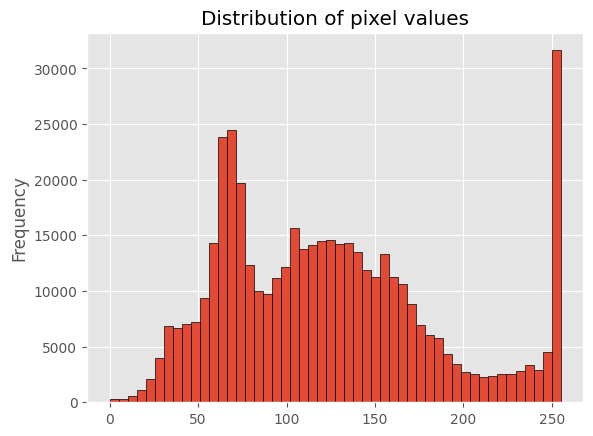

In [18]:
pd.Series(img_mpl.flatten()).plot(kind='hist', bins=50, edgecolor='black', title='Distribution of pixel values')
plt.show()

**Display Images**

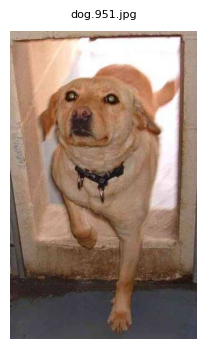

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_mpl)
ax.set_title(dog_files[random_num].split('/')[3], fontsize=8, pad=10)
ax.axis('off')
plt.show()

Looking at the channels

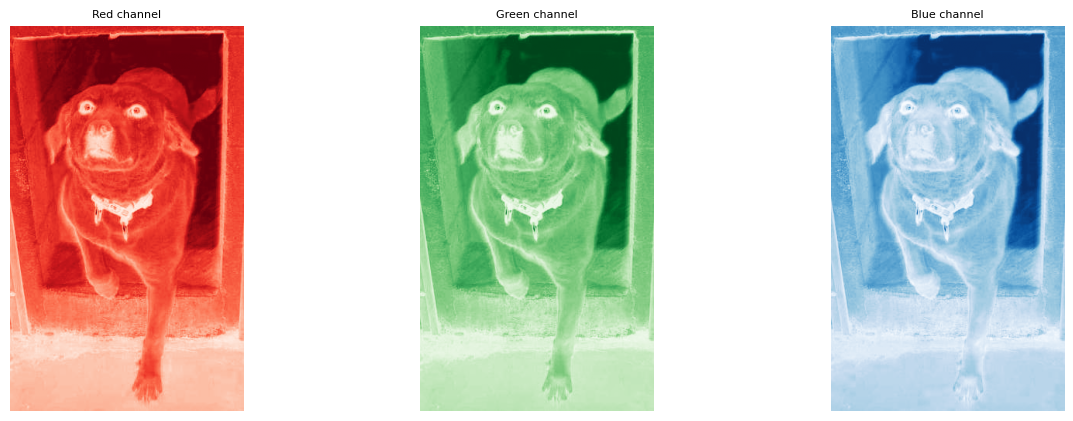

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_mpl[:,:,0], cmap='Reds')
axs[1].imshow(img_mpl[:,:,1], cmap='Greens')
axs[2].imshow(img_mpl[:,:,2], cmap='Blues')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title('Red channel', fontsize=8)
axs[1].set_title('Green channel', fontsize=8)
axs[2].set_title('Blue channel', fontsize=8)
plt.show()

In [21]:
def display_images(files):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))  # adjust figsize as needed
    
    index = random.sample(range(0,12499), 5)
    images = [files[i] for i in index]
    
    for ax, path in zip(axes, images):
        img = plt.imread(path)
        ax.imshow(img)
        ax.set_title(path.split('/')[3], fontsize=8, pad=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

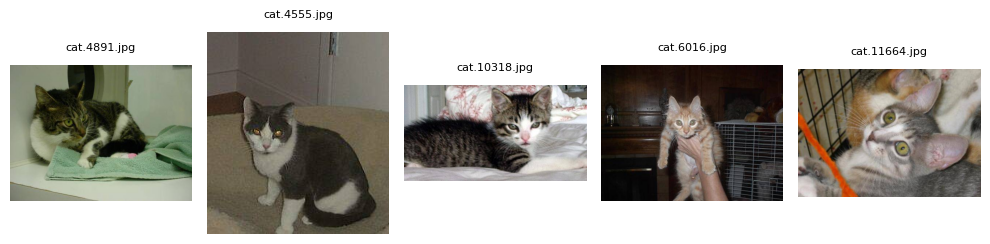

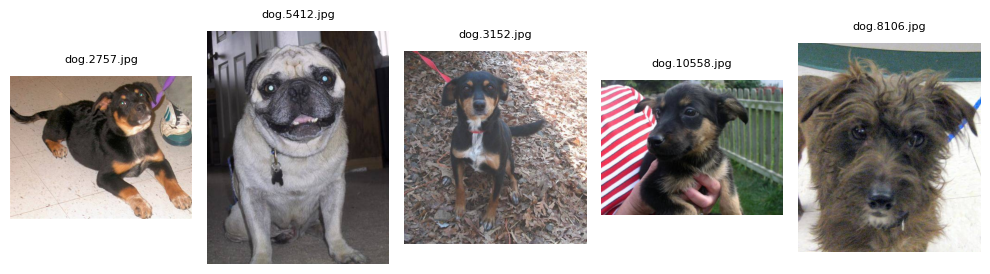

In [22]:
display_images(cat_files)
display_images(dog_files)

MPL vs CV2

* MPL: displays images in RGB
* CV2: displays images as BGR 

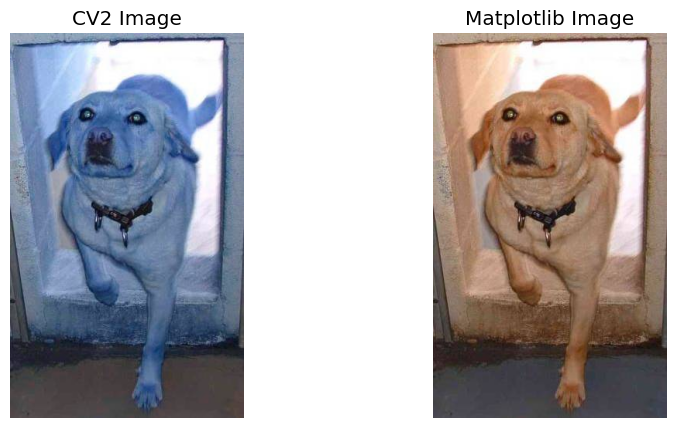

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_cv2)
axs[1].imshow(img_mpl)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('CV2 Image')
axs[1].set_title('Matplotlib Image')
plt.show()

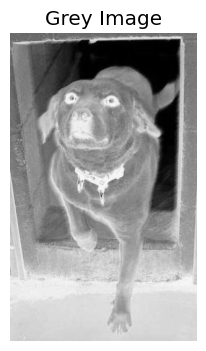

In [24]:
img_gray = cv2.cvtColor(img_mpl, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_gray, cmap='Greys')
ax.axis('off')
ax.set_title('Grey Image')
plt.show()

**checking size distribution of the images**

In [25]:
def check_size(directory_path):
    file_list = os.listdir(directory_path)
    # store image dimensions
    image_shapes = []
    
    for file in file_list:
        file_path = os.path.join(directory_path, file)
        
        try:
            img = Image.open(file_path)
            image_shapes.append(img.size)  # (width, height)
        except Exception as e:
            print(f"Error loading image: {file}: {e}")
    
    # convert to DataFrame for analysis
    df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
    print(f'\ninside directory: {directory_path}')
    print(df_shapes.describe())  # Summary statistics


In [26]:
check_size('./KaggleCatsDogs/train/')
check_size('./KaggleCatsDogs/test1/')


inside directory: ./KaggleCatsDogs/train/
             Width        Height
count  25000.00000  25000.000000
mean     404.09904    360.478080
std      109.03793     97.019959
min       42.00000     32.000000
25%      323.00000    301.000000
50%      447.00000    374.000000
75%      499.00000    421.000000
max     1050.00000    768.000000

inside directory: ./KaggleCatsDogs/test1/
              Width        Height
count  12500.000000  12500.000000
mean     404.224480    359.930720
std      109.330874     96.757411
min       37.000000     44.000000
25%      329.000000    300.000000
50%      447.000000    374.000000
75%      499.000000    418.000000
max      500.000000    500.000000


**checking color channel of all the images**

In [27]:
def check_color_channel(directory_path):
    file_list = os.listdir(directory_path)
    modes = []
    
    for file in file_list:
        file_path = os.path.join(directory_path, file)
        try:
            img = Image.open(file_path)
            modes.append(img.mode)
        except Exception as e:
            print(f"Error loading image {file}: {e}")
    
    # Create a DataFrame for analysis
    df_modes = pd.DataFrame(modes, columns=["Mode"])
    print(f'\ninside directory: {directory_path}')
    print(df_modes["Mode"].value_counts())

In [28]:
check_color_channel('./KaggleCatsDogs/train/')
check_color_channel('./KaggleCatsDogs/test1/')


inside directory: ./KaggleCatsDogs/train/
Mode
RGB    25000
Name: count, dtype: int64

inside directory: ./KaggleCatsDogs/test1/
Mode
RGB    12500
Name: count, dtype: int64


All the images are in RGB Mode

**Visualizing class distribution**

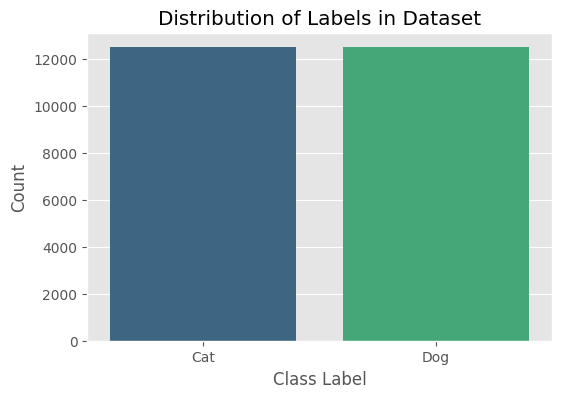

In [29]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, legend=False)

plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in Dataset")
plt.xticks(ticks=[0,1], labels=["Cat", "Dog"])  # Adjust labels if needed

plt.show()

**checking for duplicates**

In [30]:
def get_image_hash(image_path):
    """
    Open the image file and compute an MD5 hash of its bytes.
    """
    try:
        # Open image in binary mode
        with open(image_path, "rb") as f:
            file_bytes = f.read()
            # Compute MD5 hash
            image_hash = hashlib.md5(file_bytes).hexdigest()
        return image_hash
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [31]:
def check_duplicates(dataframe):
    file_list = dataframe['filename']
    
    # Dictionary to store hash as key and list of corresponding filenames as value.
    hash_dict = {}
    
    for file_path in file_list:
        image_hash = get_image_hash(file_path)
        
        # Skip if image could not be processed.
        if image_hash is None:
            continue
    
        # Append filename to list corresponding to the hash.
        if image_hash in hash_dict:
            hash_dict[image_hash].append(file_path)
        else:
            hash_dict[image_hash] = [file_path]

    duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

    print(f"Found {len(duplicates)} duplicate groups.")
    for image_hash, files in duplicates.items():
        print(f"Hash: {image_hash} -> Files: {files}")

    remove_files = []
    for i in duplicates.values():
        for j in i[1:]:
            remove_files += [j]
    return remove_files

In [32]:
def remove_duplicates(duplicate_files, dataframe):
    
    # remove rows where the filename is in the list of files to remove
    print('removed following files:')
    # print(duplicate_files)
    # pretty print
    for file in duplicate_files:
        print(file)
    return dataframe[~dataframe['filename'].isin(duplicate_files)]
    

In [33]:
# checking and removing duplicates from train set
print('duplicates in train set')
train_duplicates = check_duplicates(df)

duplicates in train set
Found 5 duplicate groups.
Hash: 61d6a61e883505354ef4357c292d779a -> Files: ['./KaggleCatsDogs/train/dog.2877.jpg', './KaggleCatsDogs/train/dog.10401.jpg', './KaggleCatsDogs/train/dog.10797.jpg']
Hash: 1ae75ef04bfbd4d81d0bf714769ef5d3 -> Files: ['./KaggleCatsDogs/train/cat.10360.jpg', './KaggleCatsDogs/train/cat.3345.jpg']
Hash: f82f16242edc7dd89e65899e33785fa2 -> Files: ['./KaggleCatsDogs/train/cat.6143.jpg', './KaggleCatsDogs/train/cat.6204.jpg']
Hash: fcfadc8c513ce6a8010abf9feea9ee00 -> Files: ['./KaggleCatsDogs/train/cat.12408.jpg', './KaggleCatsDogs/train/cat.2339.jpg']
Hash: 4184ca4717aa35e8b7aa72f88923e57c -> Files: ['./KaggleCatsDogs/train/dog.2027.jpg', './KaggleCatsDogs/train/dog.3082.jpg']


In [34]:
df = remove_duplicates(train_duplicates, df)

removed following files:
./KaggleCatsDogs/train/dog.10401.jpg
./KaggleCatsDogs/train/dog.10797.jpg
./KaggleCatsDogs/train/cat.3345.jpg
./KaggleCatsDogs/train/cat.6204.jpg
./KaggleCatsDogs/train/cat.2339.jpg
./KaggleCatsDogs/train/dog.3082.jpg


In [35]:
print('duplicates in train set')
check_duplicates(df)

duplicates in train set
Found 0 duplicate groups.


[]

Training set duplicates removed

In [36]:
# checking train set
df['label'].value_counts()

label
0    12497
1    12497
Name: count, dtype: int64

In [37]:
# checking and removing duplicates from test set
print('duplicates in test set')
test_duplicates = check_duplicates(test_df)

duplicates in test set
Found 49 duplicate groups.
Hash: 2ff183f63382885848baf8a4a8a82610 -> Files: ['./KaggleCatsDogs/test1/6687.jpg', './KaggleCatsDogs/test1/6044.jpg']
Hash: ae8a5c89708c16efe51cfaeac3f6ff0f -> Files: ['./KaggleCatsDogs/test1/3050.jpg', './KaggleCatsDogs/test1/518.jpg', './KaggleCatsDogs/test1/3252.jpg']
Hash: 44c806ebf1c024233d80b1ed49484a54 -> Files: ['./KaggleCatsDogs/test1/11779.jpg', './KaggleCatsDogs/test1/1265.jpg', './KaggleCatsDogs/test1/2421.jpg', './KaggleCatsDogs/test1/11276.jpg', './KaggleCatsDogs/test1/6383.jpg']
Hash: 298cdb7bfd5e12ce7250f61cb4a6d514 -> Files: ['./KaggleCatsDogs/test1/6284.jpg', './KaggleCatsDogs/test1/4282.jpg']
Hash: 68334621405006ff063045e2ee3b6c55 -> Files: ['./KaggleCatsDogs/test1/7032.jpg', './KaggleCatsDogs/test1/1748.jpg', './KaggleCatsDogs/test1/7780.jpg']
Hash: 0b643730d4b2ac3995e29af92f420146 -> Files: ['./KaggleCatsDogs/test1/4133.jpg', './KaggleCatsDogs/test1/2047.jpg']
Hash: cd46b623e1519237e31e453da2b918ff -> Files: ['./K

In [38]:
test_df = remove_duplicates(test_duplicates, test_df)

removed following files:
./KaggleCatsDogs/test1/6044.jpg
./KaggleCatsDogs/test1/518.jpg
./KaggleCatsDogs/test1/3252.jpg
./KaggleCatsDogs/test1/1265.jpg
./KaggleCatsDogs/test1/2421.jpg
./KaggleCatsDogs/test1/11276.jpg
./KaggleCatsDogs/test1/6383.jpg
./KaggleCatsDogs/test1/4282.jpg
./KaggleCatsDogs/test1/1748.jpg
./KaggleCatsDogs/test1/7780.jpg
./KaggleCatsDogs/test1/2047.jpg
./KaggleCatsDogs/test1/8529.jpg
./KaggleCatsDogs/test1/5714.jpg
./KaggleCatsDogs/test1/11719.jpg
./KaggleCatsDogs/test1/8332.jpg
./KaggleCatsDogs/test1/7425.jpg
./KaggleCatsDogs/test1/2434.jpg
./KaggleCatsDogs/test1/3264.jpg
./KaggleCatsDogs/test1/12196.jpg
./KaggleCatsDogs/test1/5356.jpg
./KaggleCatsDogs/test1/1378.jpg
./KaggleCatsDogs/test1/5556.jpg
./KaggleCatsDogs/test1/267.jpg
./KaggleCatsDogs/test1/10215.jpg
./KaggleCatsDogs/test1/10423.jpg
./KaggleCatsDogs/test1/7325.jpg
./KaggleCatsDogs/test1/9118.jpg
./KaggleCatsDogs/test1/9853.jpg
./KaggleCatsDogs/test1/11654.jpg
./KaggleCatsDogs/test1/750.jpg
./KaggleCats

In [39]:
print('duplicates in test set')
check_duplicates(test_df)

duplicates in test set
Found 0 duplicate groups.


[]

Test set duplicates removed

In [40]:
test_df.head()

,filename,id
0,./KaggleCatsDogs/test1/9485.jpg,9485
1,./KaggleCatsDogs/test1/6973.jpg,6973
2,./KaggleCatsDogs/test1/2233.jpg,2233
3,./KaggleCatsDogs/test1/5653.jpg,5653
4,./KaggleCatsDogs/test1/1356.jpg,1356


In [41]:
# checking duplicates in the train and test set combined

combined_filenames = pd.concat([test_df['filename'], df['filename']], ignore_index=True)
combined_df = pd.DataFrame({'filename': combined_filenames})

print('duplicates in combined set')
train_test_duplicates = check_duplicates(combined_df)

duplicates in combined set
Found 39 duplicate groups.
Hash: 0ef2bb5f02df6faab319caf7b9d9b00a -> Files: ['./KaggleCatsDogs/test1/9046.jpg', './KaggleCatsDogs/train/cat.5741.jpg']
Hash: b76b267329ce1f1ee2191b93cde8d617 -> Files: ['./KaggleCatsDogs/test1/11204.jpg', './KaggleCatsDogs/train/dog.9927.jpg']
Hash: 23f4cc9cba59a5e45d125fd8306caaf8 -> Files: ['./KaggleCatsDogs/test1/9583.jpg', './KaggleCatsDogs/train/dog.4097.jpg']
Hash: ca6e455f3eb6576a448cc828e68b912c -> Files: ['./KaggleCatsDogs/test1/2359.jpg', './KaggleCatsDogs/train/dog.1185.jpg']
Hash: 961bba2acbb6be20d49f05f12e5d384f -> Files: ['./KaggleCatsDogs/test1/4070.jpg', './KaggleCatsDogs/train/cat.10153.jpg']
Hash: 2b6d4654e8426a2125a3be0688e8046e -> Files: ['./KaggleCatsDogs/test1/8513.jpg', './KaggleCatsDogs/train/cat.10127.jpg']
Hash: 767108fd02665401d54c75155fcaa84e -> Files: ['./KaggleCatsDogs/test1/6679.jpg', './KaggleCatsDogs/train/dog.444.jpg']
Hash: 78d3762108bd362d005e80d342b27c36 -> Files: ['./KaggleCatsDogs/test1/55

In [42]:
train_test_duplicates

['./KaggleCatsDogs/train/cat.5741.jpg',
 './KaggleCatsDogs/train/dog.9927.jpg',
 './KaggleCatsDogs/train/dog.4097.jpg',
 './KaggleCatsDogs/train/dog.1185.jpg',
 './KaggleCatsDogs/train/cat.10153.jpg',
 './KaggleCatsDogs/train/cat.10127.jpg',
 './KaggleCatsDogs/train/dog.444.jpg',
 './KaggleCatsDogs/train/cat.8091.jpg',
 './KaggleCatsDogs/train/cat.3842.jpg',
 './KaggleCatsDogs/train/cat.360.jpg',
 './KaggleCatsDogs/train/dog.4805.jpg',
 './KaggleCatsDogs/train/dog.2877.jpg',
 './KaggleCatsDogs/train/cat.6096.jpg',
 './KaggleCatsDogs/train/cat.11773.jpg',
 './KaggleCatsDogs/train/dog.2265.jpg',
 './KaggleCatsDogs/train/cat.9062.jpg',
 './KaggleCatsDogs/train/cat.10238.jpg',
 './KaggleCatsDogs/train/cat.1818.jpg',
 './KaggleCatsDogs/train/cat.901.jpg',
 './KaggleCatsDogs/train/cat.8778.jpg',
 './KaggleCatsDogs/train/dog.6046.jpg',
 './KaggleCatsDogs/train/cat.4517.jpg',
 './KaggleCatsDogs/train/cat.2446.jpg',
 './KaggleCatsDogs/train/cat.846.jpg',
 './KaggleCatsDogs/train/dog.11460.jpg',

In [43]:
test_df = remove_duplicates(train_test_duplicates, test_df)

removed following files:
./KaggleCatsDogs/train/cat.5741.jpg
./KaggleCatsDogs/train/dog.9927.jpg
./KaggleCatsDogs/train/dog.4097.jpg
./KaggleCatsDogs/train/dog.1185.jpg
./KaggleCatsDogs/train/cat.10153.jpg
./KaggleCatsDogs/train/cat.10127.jpg
./KaggleCatsDogs/train/dog.444.jpg
./KaggleCatsDogs/train/cat.8091.jpg
./KaggleCatsDogs/train/cat.3842.jpg
./KaggleCatsDogs/train/cat.360.jpg
./KaggleCatsDogs/train/dog.4805.jpg
./KaggleCatsDogs/train/dog.2877.jpg
./KaggleCatsDogs/train/cat.6096.jpg
./KaggleCatsDogs/train/cat.11773.jpg
./KaggleCatsDogs/train/dog.2265.jpg
./KaggleCatsDogs/train/cat.9062.jpg
./KaggleCatsDogs/train/cat.10238.jpg
./KaggleCatsDogs/train/cat.1818.jpg
./KaggleCatsDogs/train/cat.901.jpg
./KaggleCatsDogs/train/cat.8778.jpg
./KaggleCatsDogs/train/dog.6046.jpg
./KaggleCatsDogs/train/cat.4517.jpg
./KaggleCatsDogs/train/cat.2446.jpg
./KaggleCatsDogs/train/cat.846.jpg
./KaggleCatsDogs/train/dog.11460.jpg
./KaggleCatsDogs/train/cat.730.jpg
./KaggleCatsDogs/train/cat.6852.jpg
./K

In [44]:
# checking again for combined set

combined_filenames = pd.concat([test_df['filename'], df['filename']], ignore_index=True)
combined_df = pd.DataFrame({'filename': combined_filenames})

print('duplicates in combined set')
train_test_duplicates = check_duplicates(combined_df)

duplicates in combined set
Found 39 duplicate groups.
Hash: 0ef2bb5f02df6faab319caf7b9d9b00a -> Files: ['./KaggleCatsDogs/test1/9046.jpg', './KaggleCatsDogs/train/cat.5741.jpg']
Hash: b76b267329ce1f1ee2191b93cde8d617 -> Files: ['./KaggleCatsDogs/test1/11204.jpg', './KaggleCatsDogs/train/dog.9927.jpg']
Hash: 23f4cc9cba59a5e45d125fd8306caaf8 -> Files: ['./KaggleCatsDogs/test1/9583.jpg', './KaggleCatsDogs/train/dog.4097.jpg']
Hash: ca6e455f3eb6576a448cc828e68b912c -> Files: ['./KaggleCatsDogs/test1/2359.jpg', './KaggleCatsDogs/train/dog.1185.jpg']
Hash: 961bba2acbb6be20d49f05f12e5d384f -> Files: ['./KaggleCatsDogs/test1/4070.jpg', './KaggleCatsDogs/train/cat.10153.jpg']
Hash: 2b6d4654e8426a2125a3be0688e8046e -> Files: ['./KaggleCatsDogs/test1/8513.jpg', './KaggleCatsDogs/train/cat.10127.jpg']
Hash: 767108fd02665401d54c75155fcaa84e -> Files: ['./KaggleCatsDogs/test1/6679.jpg', './KaggleCatsDogs/train/dog.444.jpg']
Hash: 78d3762108bd362d005e80d342b27c36 -> Files: ['./KaggleCatsDogs/test1/55

In [45]:
test_df.shape

(12437, 2)

In [46]:
df = remove_duplicates(train_test_duplicates, df)

removed following files:
./KaggleCatsDogs/train/cat.5741.jpg
./KaggleCatsDogs/train/dog.9927.jpg
./KaggleCatsDogs/train/dog.4097.jpg
./KaggleCatsDogs/train/dog.1185.jpg
./KaggleCatsDogs/train/cat.10153.jpg
./KaggleCatsDogs/train/cat.10127.jpg
./KaggleCatsDogs/train/dog.444.jpg
./KaggleCatsDogs/train/cat.8091.jpg
./KaggleCatsDogs/train/cat.3842.jpg
./KaggleCatsDogs/train/cat.360.jpg
./KaggleCatsDogs/train/dog.4805.jpg
./KaggleCatsDogs/train/dog.2877.jpg
./KaggleCatsDogs/train/cat.6096.jpg
./KaggleCatsDogs/train/cat.11773.jpg
./KaggleCatsDogs/train/dog.2265.jpg
./KaggleCatsDogs/train/cat.9062.jpg
./KaggleCatsDogs/train/cat.10238.jpg
./KaggleCatsDogs/train/cat.1818.jpg
./KaggleCatsDogs/train/cat.901.jpg
./KaggleCatsDogs/train/cat.8778.jpg
./KaggleCatsDogs/train/dog.6046.jpg
./KaggleCatsDogs/train/cat.4517.jpg
./KaggleCatsDogs/train/cat.2446.jpg
./KaggleCatsDogs/train/cat.846.jpg
./KaggleCatsDogs/train/dog.11460.jpg
./KaggleCatsDogs/train/cat.730.jpg
./KaggleCatsDogs/train/cat.6852.jpg
./K

# Preprocessing Image

## Data generation - offline for testing

In [47]:
# checking output folder
augmented_data_folder = './KaggleCatsDogs/train augmented'

In [50]:
datagen = ImageDataGenerator(
    rotation_range=30,        # Rotate images by up to 30 degrees
    # width_shift_range=0.2,    # Shift image horizontally (20% of width)
    # height_shift_range=0.2,   # Shift image vertically (20% of height)
    # shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom up to 20%
    horizontal_flip=True,     # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
    fill_mode='nearest'       # Fill missing pixels
)

generating 10 imgs from 1 img

In [157]:
# # Load an image (replace with your image path)
# img_path = cat_files[0]  # Change this to your image path
# img = load_img(img_path)  # Load image
# img_array = img_to_array(img)  # Convert to NumPy array
# img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch

# # Generate augmented images and save them
# image_prefix = "augmented"  # Prefix for saved images

# aug_iter = datagen.flow(
#     img_array,
#     batch_size=1,
#     save_to_dir=augmented_data_folder,  # Folder to save images
#     save_prefix=image_prefix,   # Prefix for filenames
#     save_format='jpg'           # Format of saved images
# )

# # Generate & save 2 augmented images
# for i in range(5):  
#     next(aug_iter)  # Generate and save images automatically

# print(f"Augmented images saved in '{augmented_data_folder}' folder.")


Augmented images saved in './KaggleCatsDogs/train augmented' folder.


Generating 2 images per image in the dataset

In [ ]:
# List all files in the original data folder
image_files = list(df['filename'])

# Process each image file
for i, img_path in enumerate(image_files):
    image_name = img_path.split('/')[3][:-4]
    
    # Load the image
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch

    # Create an iterator for augmentations
    aug_iter = datagen.flow(
        img_array,
        batch_size=1,
        save_to_dir=augmented_data_folder,  # Folder to save images
        save_prefix=f'augmented0_{image_name}',  # Naming convention
        save_format='jpeg'  # Format of saved images
    )

    # Generate and save the first augmented image
    next(aug_iter)

    # Update the prefix for the second augmented image
    aug_iter.save_prefix = f'augmented1_{image_name}'

    # Generate and save the second augmented image
    next(aug_iter)

    print(f"Generated 2 augmented images for '{image_name}'")

Generated 2 augmented images for 'cat.11328'
Generated 2 augmented images for 'cat.7537'
Generated 2 augmented images for 'cat.528'
Generated 2 augmented images for 'cat.6442'
Generated 2 augmented images for 'cat.5332'
Generated 2 augmented images for 'cat.8057'
Generated 2 augmented images for 'cat.8619'
Generated 2 augmented images for 'cat.6234'
Generated 2 augmented images for 'cat.2161'
Generated 2 augmented images for 'dog.10917'
Generated 2 augmented images for 'dog.3639'
Generated 2 augmented images for 'dog.2586'
Generated 2 augmented images for 'cat.11902'
Generated 2 augmented images for 'cat.3304'
Generated 2 augmented images for 'cat.11702'
Generated 2 augmented images for 'cat.12143'
Generated 2 augmented images for 'cat.10237'
Generated 2 augmented images for 'cat.181'
Generated 2 augmented images for 'cat.3854'
Generated 2 augmented images for 'cat.5970'
Generated 2 augmented images for 'dog.11299'
Generated 2 augmented images for 'dog.1215'
Generated 2 augmented image

## data Generation - Online

It minimizes disk usage and provides dynamic, varied augmentations during each training epoch.

In [158]:
datagen = ImageDataGenerator(
    rotation_range=30,        # Rotate images by up to 30 degrees
    # width_shift_range=0.2,    # Shift image horizontally (20% of width)
    # height_shift_range=0.2,   # Shift image vertically (20% of height)
    # shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom up to 20%
    horizontal_flip=True,     # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
    fill_mode='nearest'       # Fill missing pixels
)

## Data conversion

convert cv2 color to RGB

resize every image to 128,128

normalize images

In [159]:
x_train = []
for img in df['filename']:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img/255.0
    x_train.append(img)
x_train = np.array(x_train)

In [160]:
y_train = df[['label']]

In [161]:
x_train.shape, y_train.shape

((24994, 128, 128, 3), (24994, 1))

In [162]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)